## Exploratory Data Analysis and Visualization 

In [3]:
# Import libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KernelDensity
plt.style.use('fivethirtyeight')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [8]:
# Load data
train = pd.read_csv('assets/working/combined_train.csv')
test = pd.read_csv('assets/working/combined_test.csv')
spray = pd.read_csv('assets/input/spray.csv')

#### Transform data

Before we explore the data, we must first change categorical values into numerical representations. Species is the only column that requires this transformation. 

In [4]:
# Define function to ensure equal columns in the train and test datasets
def leveller(train, test):
    tr_features = set(train.columns)
    te_features = set(test.columns)
    for missing_col in tr_features - te_features:
        test[missing_col] = 0
    return train, test[train.columns]

In [5]:
# Define function to dummy species column in train and test datasets
def split_species(train, test):
    train_full = pd.get_dummies(train, columns = ['Species'])
    test_full = pd.get_dummies(test, columns = ['Species'])
    return train_full, test_full

In [6]:
# Dummy species column and ensure train and test datasets have same columns
train, test = split_species(train, test)
train, test = leveller(train, test)
train.columns

Index(['Longitude', 'Latitude', 'Trap', 'Station', 'Date', 'Tavg', 'WetBulb',
       'PrecipTotal', 'AvgSpeed', 'Heat', 'Cool', 'Tmax', 'Tmin', 'DewPoint',
       'ResultSpeed', 'ResultDir', 'StnPressure', 'SeaLevel', 'Rain',
       'Sunrise', 'Sunset', 'WnvPresent', 'Species_CULEX ERRATICUS',
       'Species_CULEX PIPIENS', 'Species_CULEX PIPIENS/RESTUANS',
       'Species_CULEX RESTUANS', 'Species_CULEX SALINARIUS',
       'Species_CULEX TARSALIS', 'Species_CULEX TERRITANS'],
      dtype='object')

#### Visualize data

First we will look at distributions of the features and target

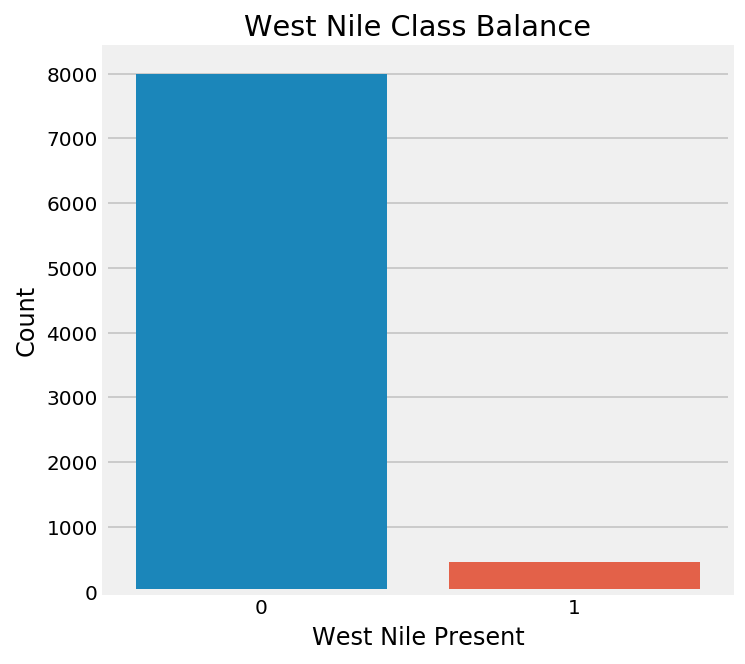

In [6]:
# West Nile Present class balance
fig = plt.figure(figsize = (5,5))
sns.barplot(x = [0,1], y = train['WnvPresent'].value_counts())
plt.xlabel('West Nile Present')
plt.ylabel('Count')
plt.title('West Nile Class Balance');

In [7]:
# Only 5% of our observations have West Nile 
train['WnvPresent'].value_counts(normalize = True)

0    0.945936
1    0.054064
Name: WnvPresent, dtype: float64

Our classes are very unbalanced for our target variable, WnvPresent. We will keep this in mind when modeling, since our models will be less accurate with unbalanced classes. In order to solve this we can look at the following options before modeling:
* Oversampling the WnvPresent == 1 class
* Bootstrapping
* Stratifying

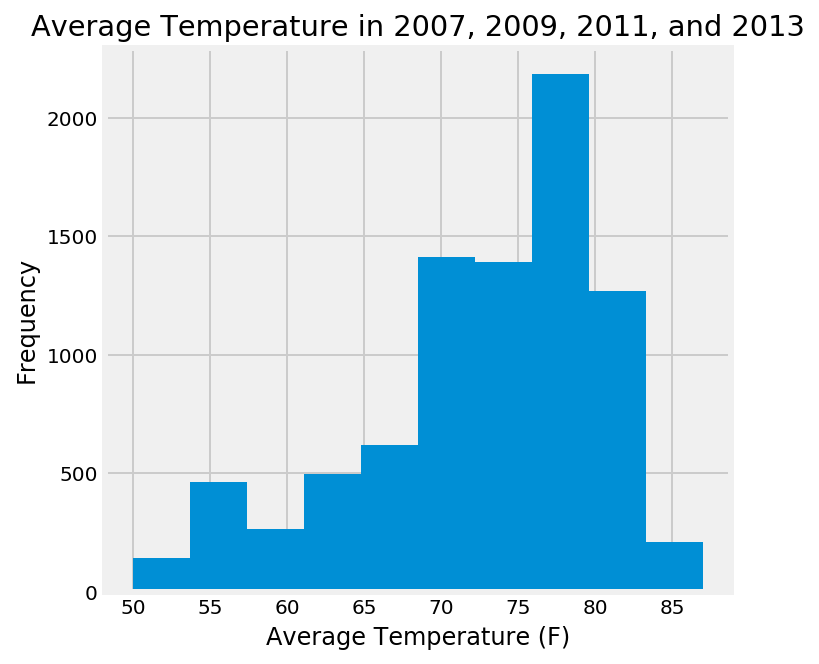

In [8]:
# Average temperature distribution 
fig = plt.figure(figsize = (5,5))
train['Tavg'].plot(kind='hist')
plt.xlabel('Average Temperature (F)')
plt.title('Average Temperature in 2007, 2009, 2011, and 2013');

In [3]:
# Create year, month, day columns to examine trends 
train['Year'] = train['Date'].apply(lambda x: x[:4])
train['Month'] = train['Date'].apply(lambda x: x[5:7])
train['Day'] = train['Date'].apply(lambda x: x[8:])

test['Year'] = test['Date'].apply(lambda x: x[:4])
test['Month'] = test['Date'].apply(lambda x: x[5:7])
test['Day'] = test['Date'].apply(lambda x: x[8:])

spray['Year'] = spray['Date'].map(lambda x: x[:4])

# Drop Date column
train.drop('Date', axis = 1, inplace = True)
test.drop('Date', axis = 1, inplace = True)

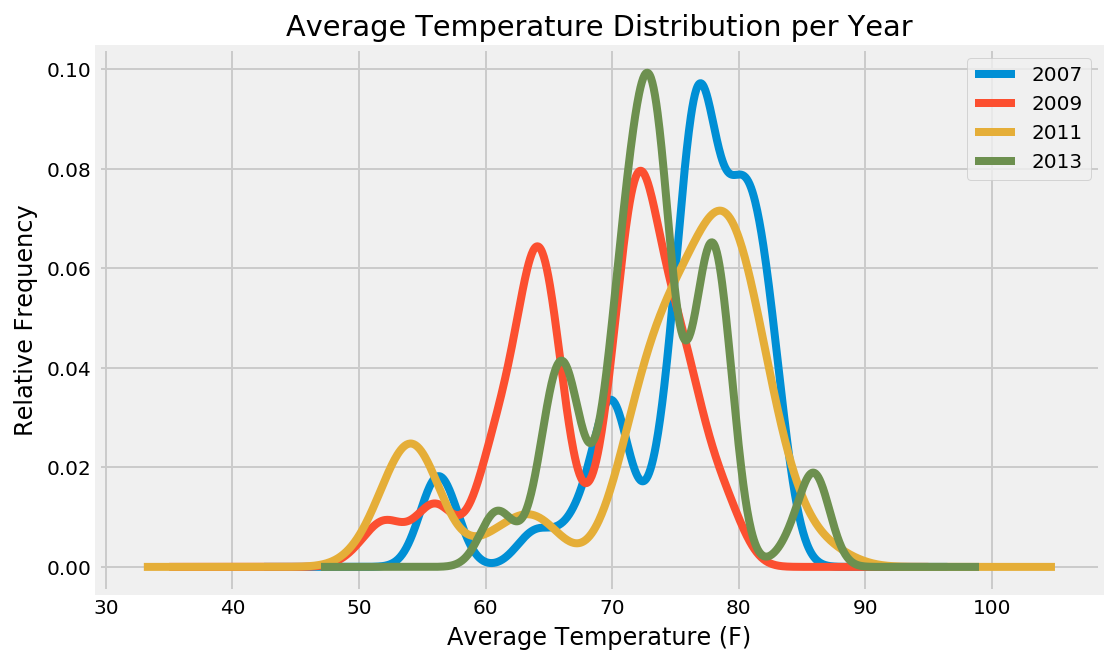

In [10]:
# Average temperature distributions per year 
fig = plt.figure(figsize = (8,5))
train.groupby('Year')['Tavg'].plot(kind = 'kde')
plt.xlabel("Average Temperature (F)")
plt.ylabel('Relative Frequency')
plt.title('Average Temperature Distribution per Year')
plt.legend();

In [12]:
# Determine median temperature per year 
train.groupby('Year')['Tavg'].median()

Year
2007    77.0
2009    71.0
2011    77.0
2013    73.0
Name: Tavg, dtype: float64

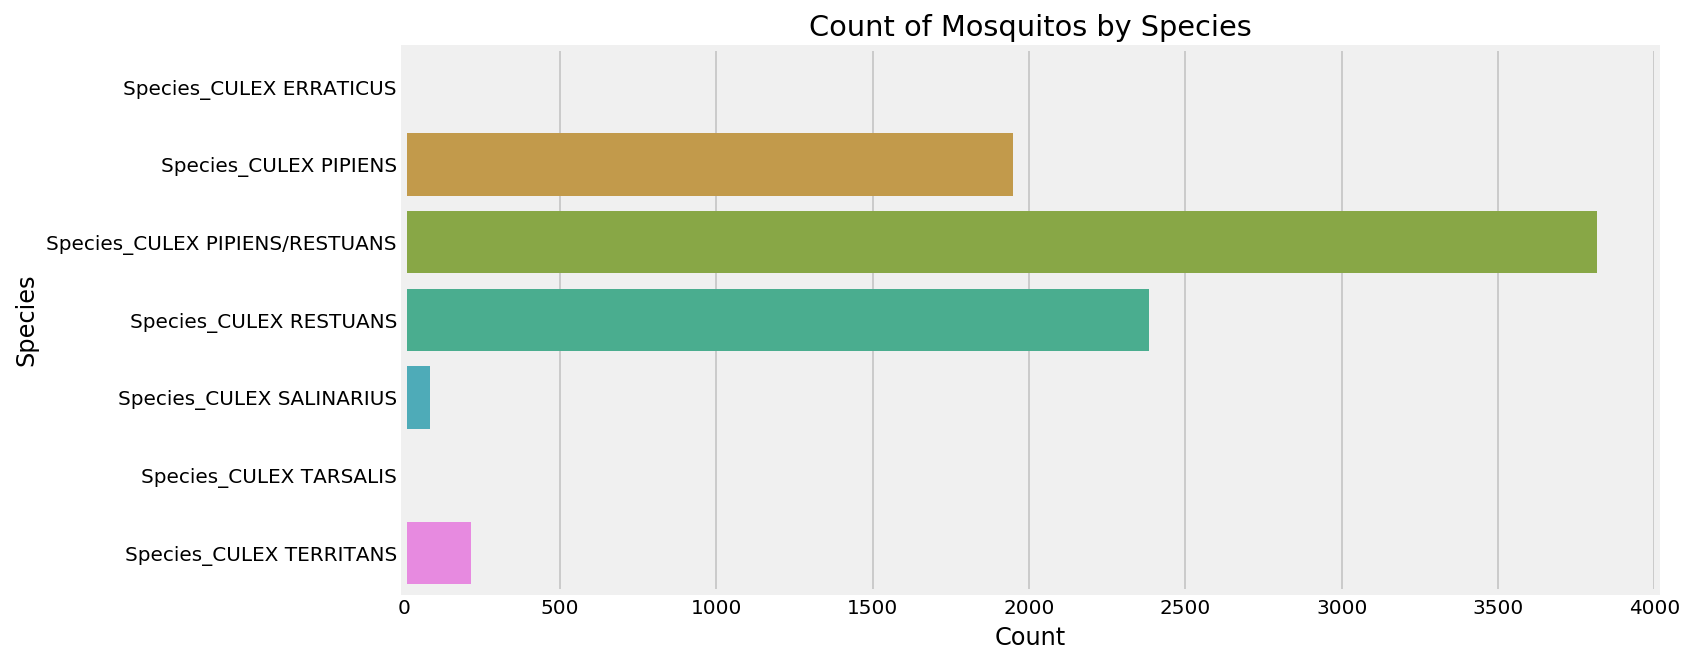

In [13]:
# Plot of species counts
species = [col for col in train.columns if col.startswith("Species")]
fig = plt.figure(figsize = (10, 5))
sns.barplot(x = train[species].sum(), y = species)
plt.xlabel('Count')
plt.ylabel('Species')
plt.title('Count of Mosquitos by Species');

Culex Pipiens and Restuans represent the majority of species by count. 

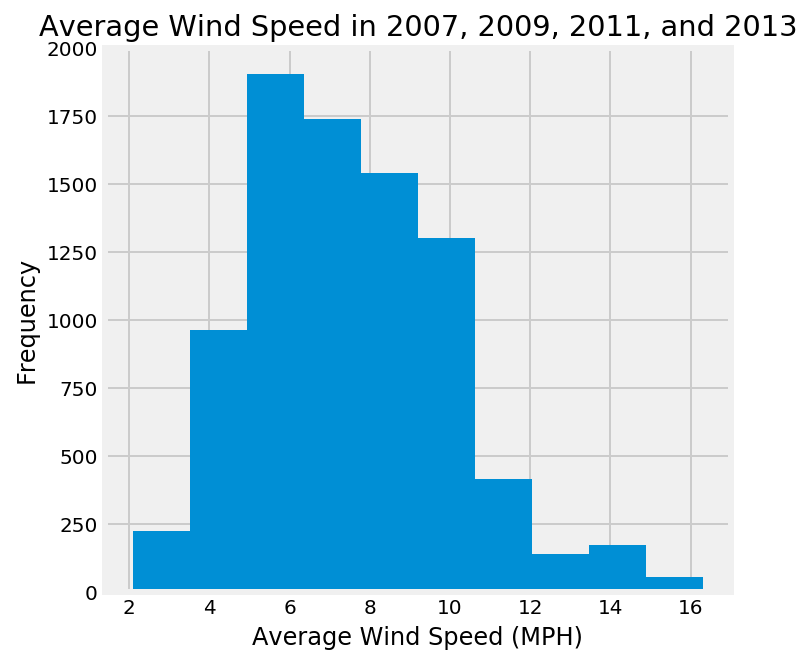

In [14]:
# Average wind speed distribution 
fig = plt.figure(figsize = (5,5))
train['AvgSpeed'].plot(kind = 'hist')
plt.xlabel('Average Wind Speed (MPH)')
plt.title('Average Wind Speed in 2007, 2009, 2011, and 2013');

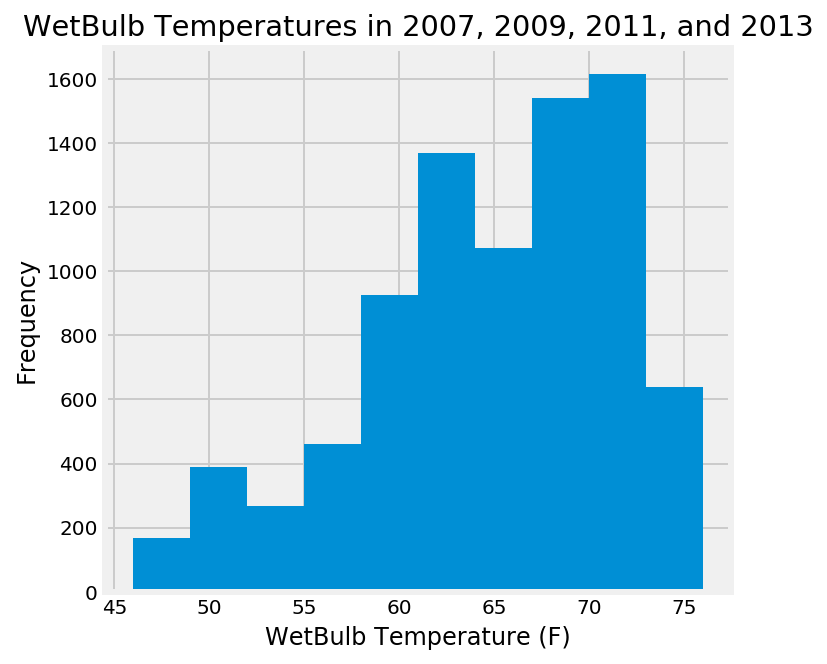

In [15]:
# WetBulb Distribution - wetbulb indicates humidity 
fig = plt.figure(figsize = (5,5))
train['WetBulb'].plot(kind='hist')
plt.xlabel('WetBulb Temperature (F)')
plt.title('WetBulb Temperatures in 2007, 2009, 2011, and 2013');

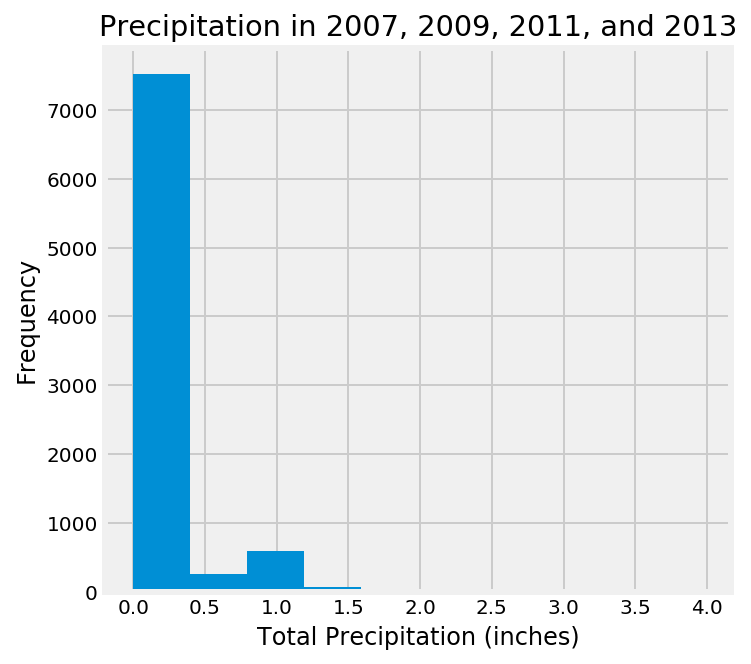

In [16]:
# Precipitation Distribution 
fig = plt.figure(figsize = (5,5))
train['PrecipTotal'].plot(kind='hist')
plt.xlabel('Total Precipitation (inches)')
plt.title('Precipitation in 2007, 2009, 2011, and 2013');

Most days seem to be dry or have very little precipitation

#### Map Visualizations

In [13]:
# Load map
mapdata = np.loadtxt("assets/input/mapdata_copyright_openstreetmap_contributors.txt")

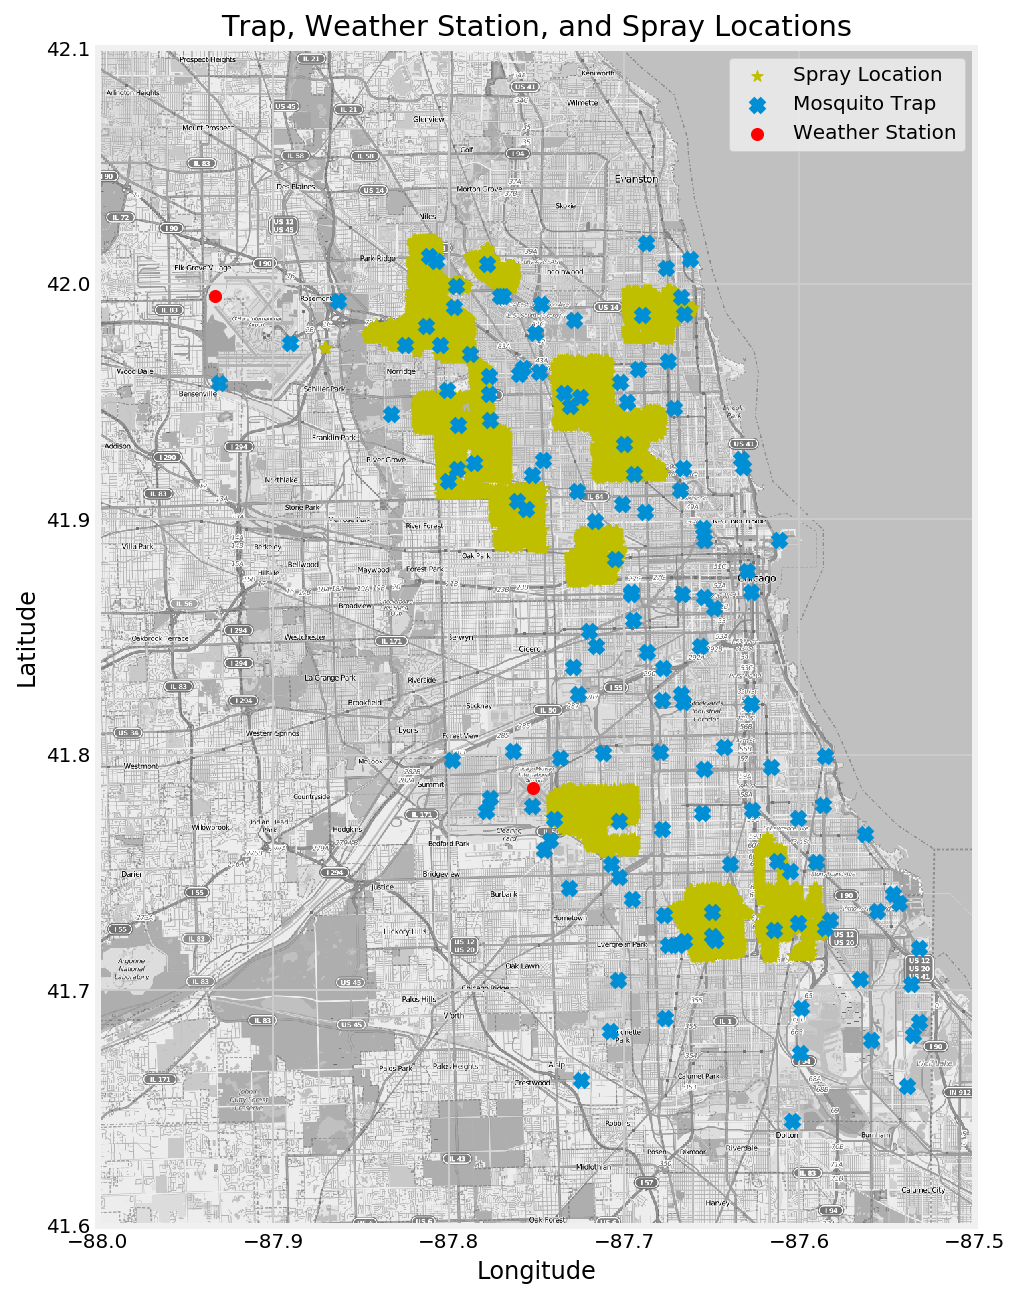

In [14]:
# Map trap, weather station, and spray locations 
fig = plt.figure(figsize = (7,12))

# Show map in desired lat, long range 
plt.imshow(mapdata, cmap = plt.get_cmap('gray'), extent = (-88, -87.5, 41.6, 42.1),
           aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1])

# Scatter plot for spray locations (removing outliers far away from the rest of the traps)
spray_loc = spray[['Longitude', 'Latitude','Year']].drop_duplicates()
spray_loc = spray_loc[spray_loc['Latitude'] < 42.3]
plt.scatter(spray_loc['Longitude'], spray_loc['Latitude'], marker = '*', color = 'y', label = "Spray Location")

# Scatter plot for trap locations 
traps = train[['Longitude', 'Latitude']].drop_duplicates().values
plt.scatter(traps[:,0], traps[:,1], marker='x', label = "Mosquito Trap")

# Scatter plot for weather station locations
plt.scatter(x = [-87.933, -87.752], y = [41.995, 41.786], marker = 'o', c = 'r', label = 'Weather Station')

# Labels
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Trap, Weather Station, and Spray Locations')
plt.legend();

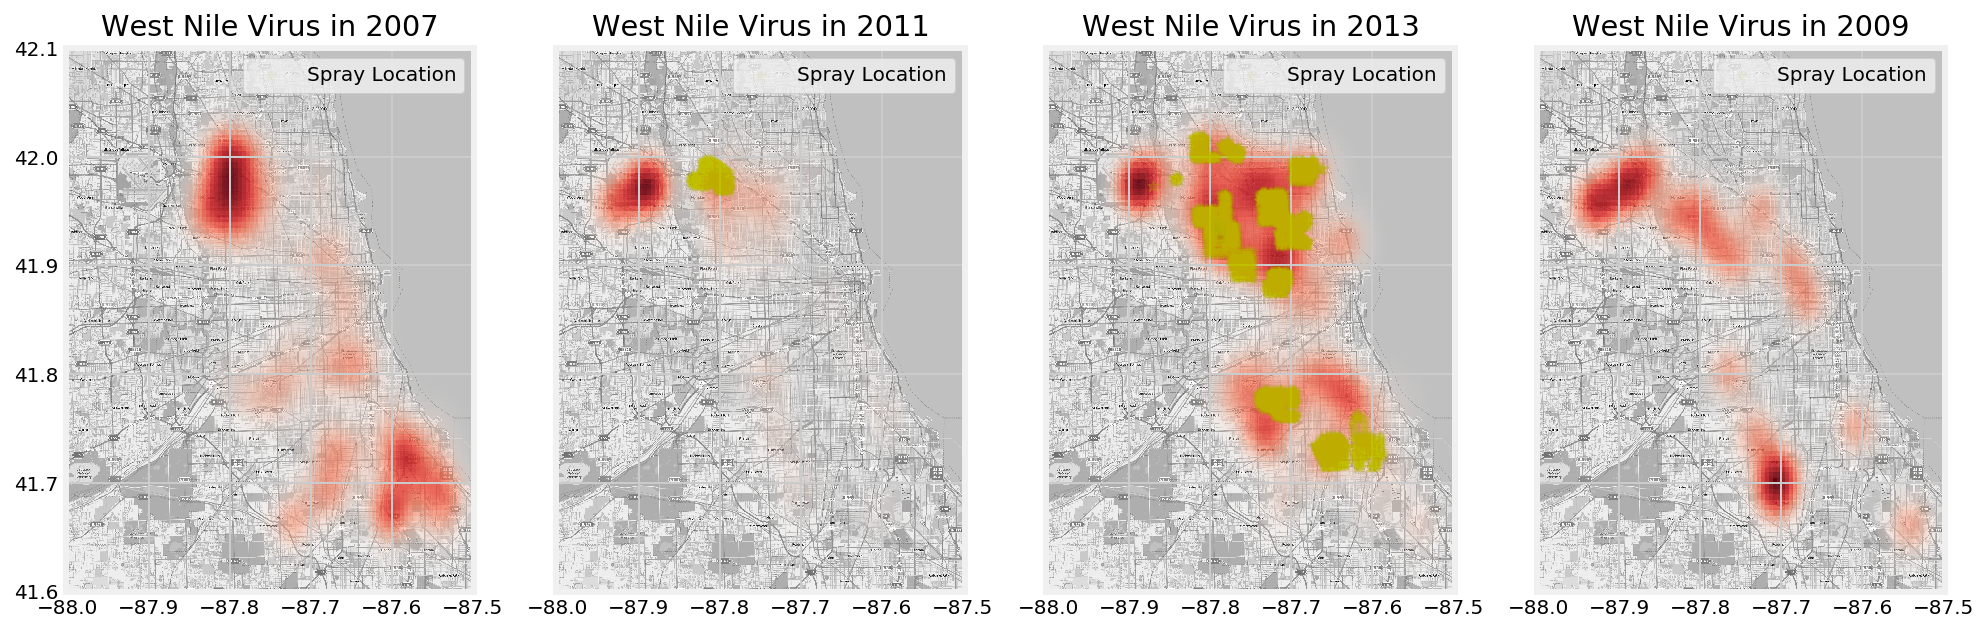

In [15]:
# Map trap and west nile heatmap 
fig, ax = plt.subplots(figsize = (15,5),nrows = 1, ncols = 4, sharey = True)

for idx, year in enumerate(train['Year'].unique()):

    # Show map in desired lat, long range 
    axis = ax[idx]
    axis.imshow(mapdata, cmap = plt.get_cmap('gray'), extent = (-88, -87.5, 41.6, 42.1),
               aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1])
    
    # Scatter plot for trap locations 
    traps = train[['Longitude', 'Latitude']].drop_duplicates().values
    
    # Plot a density map of West Nile Virus sighting
    alphas = plt.cm.Reds
    alphas._init()
    alphas._lut[:-3, -1] = abs(np.logspace(0,1,alphas.N) / 10 - 1)[::-1]
    virus_locs = train[['Longitude','Latitude']][(train['WnvPresent'] == 1) & (train['Year'] == year)]
    kern = KernelDensity(bandwidth = 0.02)
    kern.fit(virus_locs.values)
    xv, yv = np.meshgrid(np.linspace(-88, -87.5, 100), np.linspace(41.6, 42.1, 100))
    gridpoints = np.array([xv.ravel(), yv.ravel()]).T
    zv = np.exp(kern.score_samples(gridpoints).reshape(100,100))
    axis.imshow(zv,
               origin = 'lower',
              cmap = alphas,
              extent = (-88, -87.5, 41.6, 42.1),
              aspect = mapdata.shape[0]*1.0/mapdata.shape[1])

    # Scatter plot for spray locations (removing outliers far away from the rest of the traps)
    current = spray_loc[spray_loc['Year']==year]
    axis.scatter(current['Longitude'], current['Latitude'], marker = '*', color = 'y', label = "Spray Location", alpha=0.05)

    # Labels
    axis.set_title(f"West Nile Virus in {year}")
    axis.legend();

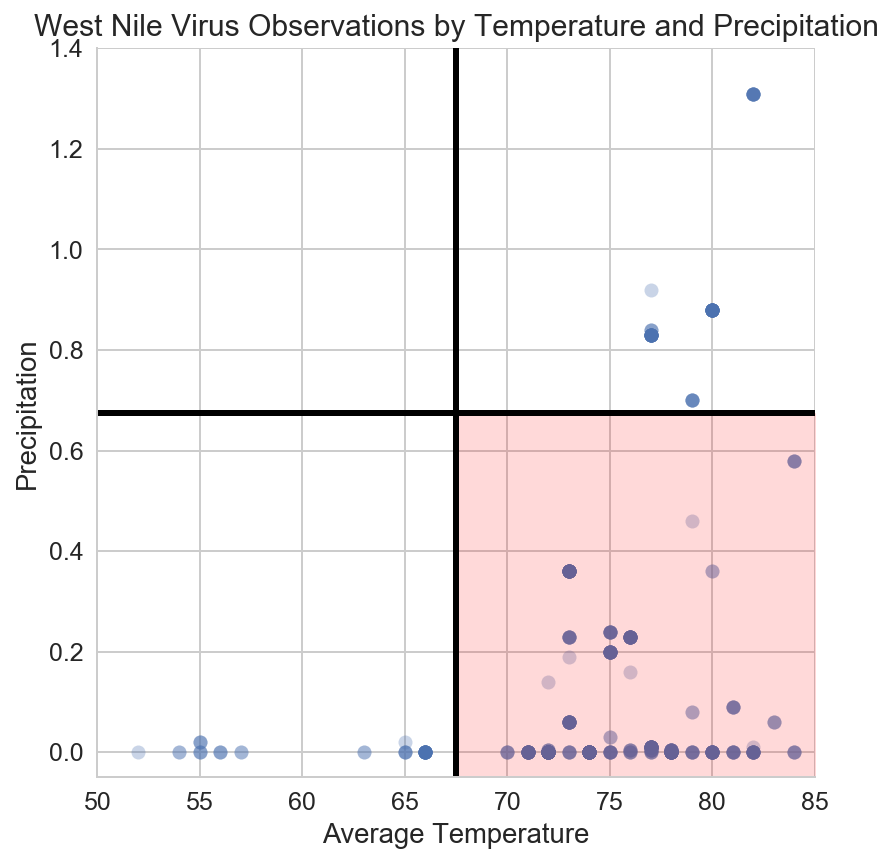

In [136]:
# Visualize the relationship between West Nile Virus and Temperature/Precipitation 
temp_precip_wnv_df = train[['Tavg', 'PrecipTotal', 'WnvPresent']]

sns.set(font_scale=1.25, style='whitegrid')
sns.lmplot('Tavg','PrecipTotal', data = temp_precip_wnv_df[temp_precip_wnv_df['WnvPresent']==1], fit_reg = False, size = 6, scatter_kws = {'alpha':0.3})

# Labels
plt.title("West Nile Virus Observations by Temperature and Precipitation")
plt.xlim(50, 85)
plt.ylim(-0.05, 1.4)
plt.hlines(y =(1.4 + (-.05))/2, xmin = 50, xmax = 85, color = 'black', lw = 3)
plt.vlines(x = (85+50)/2, ymin = -0.05, ymax = 1.4, lw = 3)
plt.xlabel("Average Temperature")
plt.ylabel("Precipitation")

# Color lower right quadrant 
plt.fill_between([(85+50)/2, 85], -0.05, (1.4 + (-.05))/2, color='red', alpha='0.15')

plt.show()

#### Save to CSV

In [20]:
# Save train and test dataframes to csv with feature engineering updates 
train.to_csv('assets/working/feat_train.csv',index=False)
test.to_csv('assets/working/feat_test.csv',index=False)
spray.to_csv('assets/working/feat_spray.csv', index = False)